In [51]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
from pymle.models import GeometricBM, OrnsteinUhlenbeck
from pymle.core.TransitionDensity import KesslerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE
import aleatory
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import aleatory.processes as an
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge # Import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error


In [52]:
pd.options.display.max_rows = 500
day=0
market_data = pd.read_csv(f'/Users/zackienzle/Library/CloudStorage/OneDrive-Personal/DEV/Projects/Quant Preparation/Assigned/IMC/Prosperity25/prices_round_1_day_{day}.csv', sep=';', header=0)
trade_history = pd.read_csv(f"/Users/zackienzle/Library/CloudStorage/OneDrive-Personal/DEV/Projects/Quant Preparation/Assigned/IMC/Prosperity25/trades_round_1_day_{day}.csv", sep=";", header=0)
market_data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,RAINFOREST_RESIN,9998,1,9995.0,30.0,NaN,NaN,10005,30,NaN,NaN,NaN,NaN,10001.5,0.0
1,0,0,KELP,2028,30,NaN,NaN,NaN,NaN,2032,30,NaN,NaN,NaN,NaN,2030.0,0.0
2,0,0,SQUID_INK,1968,30,NaN,NaN,NaN,NaN,1971,30,NaN,NaN,NaN,NaN,1969.5,0.0
3,0,100,SQUID_INK,1969,4,1967.0,31.0,NaN,NaN,1971,31,NaN,NaN,NaN,NaN,1970.0,0.0
4,0,100,KELP,2030,4,2028.0,31.0,NaN,NaN,2032,31,NaN,NaN,NaN,NaN,2031.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,999800,KELP,2032,27,NaN,NaN,NaN,NaN,2034,1,2035.0,27.0,NaN,NaN,2033.0,0.0
29996,0,999800,RAINFOREST_RESIN,9995,27,NaN,NaN,NaN,NaN,10005,27,NaN,NaN,NaN,NaN,10000.0,0.0
29997,0,999900,RAINFOREST_RESIN,9996,2,9995.0,21.0,NaN,NaN,10004,2,10005.0,21.0,NaN,NaN,10000.0,0.0
29998,0,999900,SQUID_INK,1838,23,NaN,NaN,NaN,NaN,1841,23,NaN,NaN,NaN,NaN,1839.5,0.0


In [53]:
kelp_data = market_data[market_data['product'] == 'KELP'].reset_index(drop=True)
kelp_data['bid_volume_1'].value_counts()

bid_volume_1
1     985
24    710
27    694
28    692
26    691
29    685
30    684
25    660
22    644
23    592
31    491
21    458
2     353
32    265
20    244
5     170
4     169
3     161
6     121
7      90
8      74
34     62
33     61
9      39
36     37
35     36
37     22
19     21
38     20
10     15
18     11
39      9
16      7
17      6
15      6
14      4
11      4
12      4
13      2
40      1
Name: count, dtype: int64

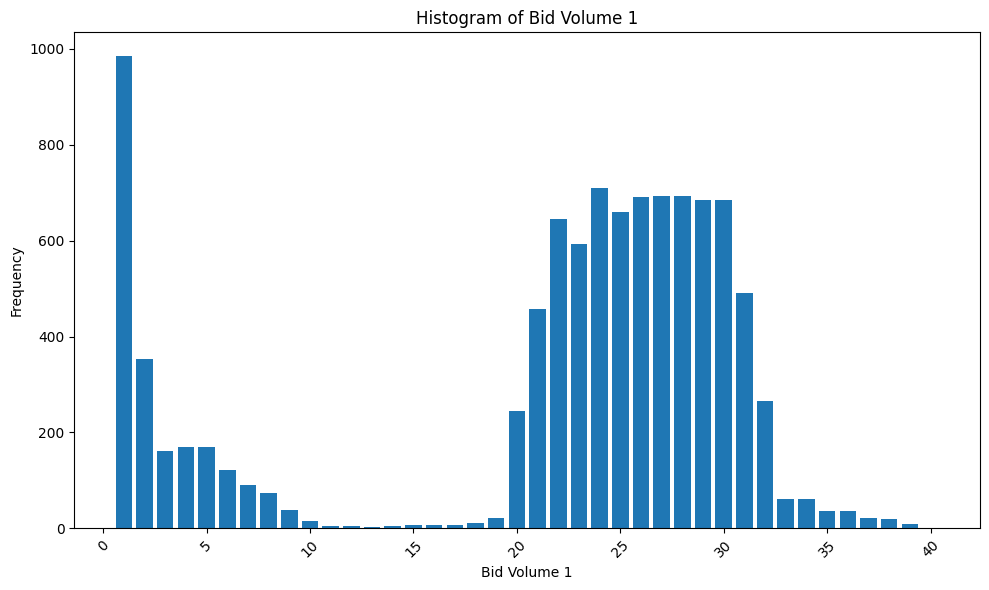

In [54]:
bid_volume_counts = kelp_data['bid_volume_1'].value_counts()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(bid_volume_counts.index, bid_volume_counts.values)
plt.xlabel('Bid Volume 1')
plt.ylabel('Frequency')
plt.title('Histogram of Bid Volume 1')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

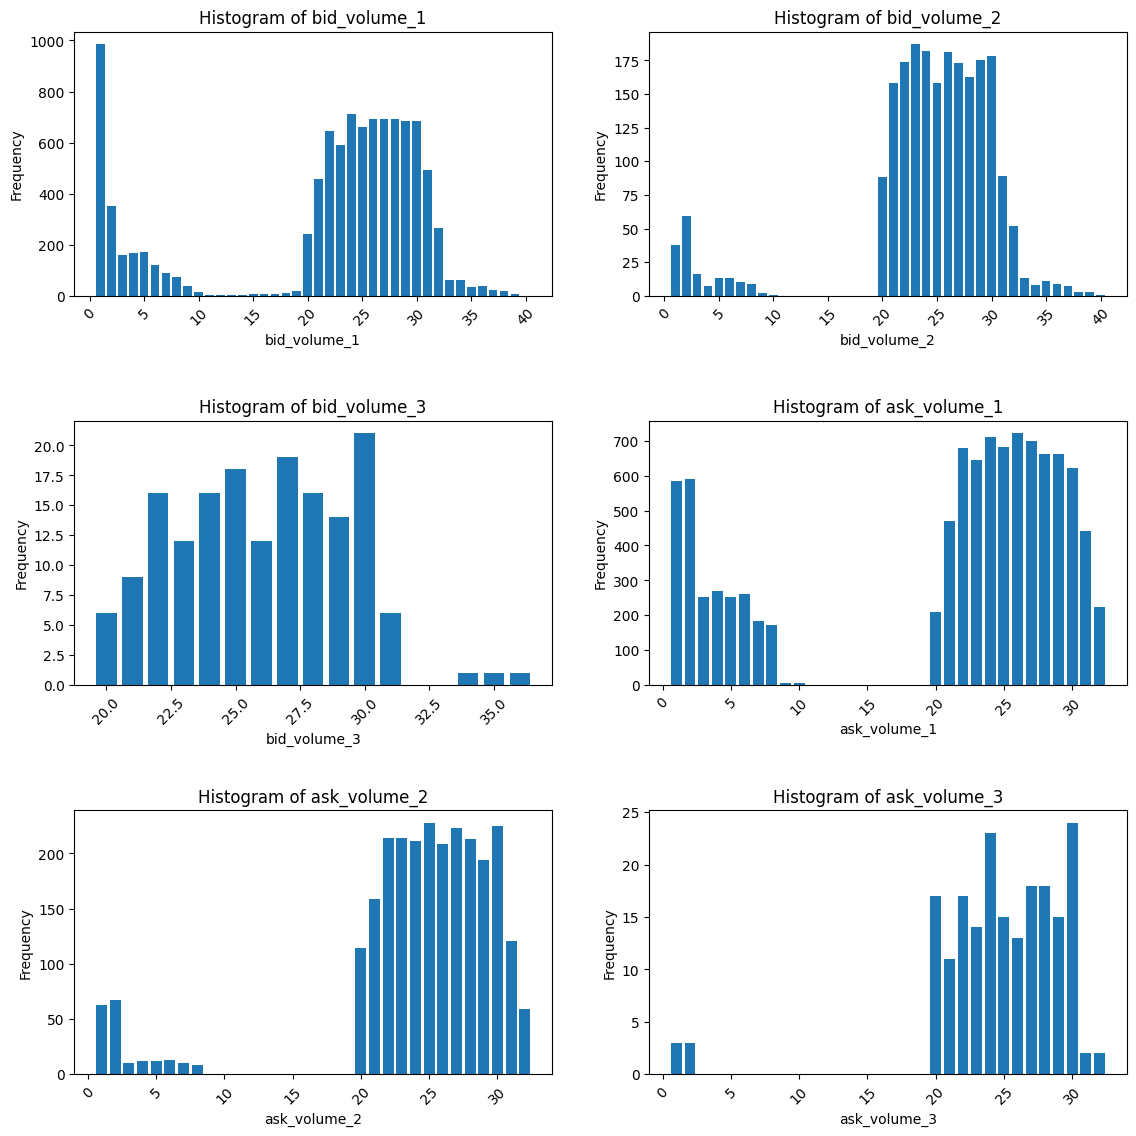

In [55]:
columns_to_plot = ['bid_volume_1', 'bid_volume_2', 'bid_volume_3',
                   'ask_volume_1', 'ask_volume_2', 'ask_volume_3']

num_plots = len(columns_to_plot)
num_rows = (num_plots + 1) // 2
num_cols = 2

plt.figure(figsize=(12, 4 * num_rows))

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(num_rows, num_cols, i)
    
    volume_counts = kelp_data[column].value_counts()
    
    plt.bar(volume_counts.index, volume_counts.values)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout(pad=3.0)

plt.show();

In [56]:
def calculate_mm_mid(row):
    # Find the best bid with volume >= 20
    for i in range(1, 4):
        if row[f'bid_volume_{i}'] >= 20:
            best_bid = row[f'bid_price_{i}']
            break
    else:
        best_bid = None

    for i in range(1, 4):
        if row[f'ask_volume_{i}'] >= 20:
            best_ask = row[f'ask_price_{i}']
            break
    else:
        best_ask = None

    # Calculate the mid price if both best bid and ask are found
    if best_bid is not None and best_ask is not None:
        return (best_bid + best_ask) / 2
    else:
        return None

kelp_data['mm_mid'] = kelp_data.apply(calculate_mm_mid, axis=1)
kelp_data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,mm_mid
0,0,0,KELP,2028,30,NaN,NaN,NaN,NaN,2032,30,NaN,NaN,NaN,NaN,2030.0,0.0,2030.0
1,0,100,KELP,2030,4,2028.0,31.0,NaN,NaN,2032,31,NaN,NaN,NaN,NaN,2031.0,0.0,2030.0
2,0,200,KELP,2029,1,2028.0,21.0,NaN,NaN,2032,22,NaN,NaN,NaN,NaN,2030.5,0.0,2030.0
3,0,300,KELP,2029,25,NaN,NaN,NaN,NaN,2032,25,NaN,NaN,NaN,NaN,2030.5,0.0,2030.5
4,0,400,KELP,2029,2,2028.0,23.0,NaN,NaN,2030,6,2032.0,25.0,NaN,NaN,2029.5,0.0,2030.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,999500,KELP,2032,28,NaN,NaN,NaN,NaN,2035,28,NaN,NaN,NaN,NaN,2033.5,0.0,2033.5
9996,0,999600,KELP,2032,36,NaN,NaN,NaN,NaN,2035,29,NaN,NaN,NaN,NaN,2033.5,0.0,2033.5
9997,0,999700,KELP,2034,1,2032.0,26.0,NaN,NaN,2035,26,NaN,NaN,NaN,NaN,2034.5,0.0,2033.5
9998,0,999800,KELP,2032,27,NaN,NaN,NaN,NaN,2034,1,2035.0,27.0,NaN,NaN,2033.0,0.0,2033.5


In [57]:
# Create the plot using Plotly Express
fig = px.line(kelp_data, x='timestamp', y='mm_mid', title='MM Mid Price Over Time')

# Customize the layout
fig.update_layout(
    xaxis_title='Timestamp',
    yaxis_title='MM Mid Price',
)

# Display the plot
fig.show()

In [58]:
kelp_fair_prices = kelp_data[['timestamp', 'mm_mid']]

In [59]:
kelp_fair_prices = kelp_fair_prices.rename(columns={'mm_mid': 'fair'})
kelp_fair_prices

,timestamp,fair
0,0,2030.0
1,100,2030.0
2,200,2030.0
3,300,2030.5
4,400,2030.0
...,...,...
9995,999500,2033.5
9996,999600,2033.5
9997,999700,2033.5
9998,999800,2033.5


In [60]:
iteration_counts = [1,2,5,10,50, 100, 500,]

In [61]:
for iterations in iteration_counts:
    kelp_fair_prices[f"fair_in_{iterations}_its"] = kelp_fair_prices['fair'].shift(-iterations)
    kelp_fair_prices[f"fair_{iterations}_its_ago"] = kelp_fair_prices['fair'].shift(iterations)
kelp_fair_prices

,timestamp,fair,fair_in_1_its,fair_1_its_ago,fair_in_2_its,fair_2_its_ago,fair_in_5_its,fair_5_its_ago,fair_in_10_its,fair_10_its_ago,fair_in_50_its,fair_50_its_ago,fair_in_100_its,fair_100_its_ago,fair_in_500_its,fair_500_its_ago
0,0,2030.0,2030.0,NaN,2030.0,NaN,2029.5,NaN,2030.5,NaN,2030.0,NaN,2031.5,NaN,2030.5,NaN
1,100,2030.0,2030.0,2030.0,2030.5,NaN,2029.5,NaN,2030.5,NaN,2030.0,NaN,2031.5,NaN,2030.5,NaN
2,200,2030.0,2030.5,2030.0,2030.0,2030.0,2030.0,NaN,2031.0,NaN,2030.0,NaN,2031.5,NaN,2030.0,NaN
3,300,2030.5,2030.0,2030.0,2029.5,2030.0,2030.0,NaN,2031.0,NaN,2030.5,NaN,2031.5,NaN,2030.5,NaN
4,400,2030.0,2029.5,2030.5,2029.5,2030.0,2030.5,NaN,2031.0,NaN,2030.5,NaN,2031.5,NaN,2030.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,999500,2033.5,2033.5,2033.5,2033.5,2033.5,NaN,2033.5,NaN,2033.5,NaN,2033.5,NaN,2033.0,NaN,2035.5
9996,999600,2033.5,2033.5,2033.5,2033.5,2033.5,NaN,2033.5,NaN,2033.5,NaN,2033.5,NaN,2033.5,NaN,2035.5
9997,999700,2033.5,2033.5,2033.5,2033.5,2033.5,NaN,2033.5,NaN,2033.5,NaN,NaN,NaN,2033.0,NaN,2035.5
9998,999800,2033.5,2033.5,2033.5,NaN,2033.5,NaN,2033.5,NaN,2033.5,NaN,2033.5,NaN,2033.0,NaN,2035.5


In [62]:
for iterations in iteration_counts:
    kelp_fair_prices[f'returns_in_{iterations}_its'] = (kelp_fair_prices[f'fair_in_{iterations}_its'] - kelp_fair_prices['fair'])/kelp_fair_prices['fair']
    kelp_fair_prices[f'returns_from_{iterations}_its_ago'] = (kelp_fair_prices['fair'] - kelp_fair_prices[f'fair_{iterations}_its_ago'])/kelp_fair_prices[f'fair_{iterations}_its_ago']
kelp_fair_prices.columns

Index(['timestamp', 'fair', 'fair_in_1_its', 'fair_1_its_ago', 'fair_in_2_its',
       'fair_2_its_ago', 'fair_in_5_its', 'fair_5_its_ago', 'fair_in_10_its',
       'fair_10_its_ago', 'fair_in_50_its', 'fair_50_its_ago',
       'fair_in_100_its', 'fair_100_its_ago', 'fair_in_500_its',
       'fair_500_its_ago', 'returns_in_1_its', 'returns_from_1_its_ago',
       'returns_in_2_its', 'returns_from_2_its_ago', 'returns_in_5_its',
       'returns_from_5_its_ago', 'returns_in_10_its',
       'returns_from_10_its_ago', 'returns_in_50_its',
       'returns_from_50_its_ago', 'returns_in_100_its',
       'returns_from_100_its_ago', 'returns_in_500_its',
       'returns_from_500_its_ago'],
      dtype='object')

In [63]:
kelp_returns = kelp_fair_prices[['timestamp','fair','returns_in_1_its', 'returns_from_1_its_ago',
       'returns_in_2_its', 'returns_from_2_its_ago', 'returns_in_5_its',
       'returns_from_5_its_ago', 'returns_in_10_its',
       'returns_from_10_its_ago', 'returns_in_50_its',
       'returns_from_50_its_ago', 'returns_in_100_its',
       'returns_from_100_its_ago', 'returns_in_500_its',
       'returns_from_500_its_ago']]

In [64]:
kelp_returns= kelp_returns.dropna()
kelp_returns

,timestamp,fair,returns_in_1_its,returns_from_1_its_ago,returns_in_2_its,returns_from_2_its_ago,returns_in_5_its,returns_from_5_its_ago,returns_in_10_its,returns_from_10_its_ago,returns_in_50_its,returns_from_50_its_ago,returns_in_100_its,returns_from_100_its_ago,returns_in_500_its,returns_from_500_its_ago
500,50000,2030.5,0.000000,-0.000246,-0.000246,-0.000246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000246,0.000000,0.000246,-0.000492,0.000246
502,50200,2030.0,0.000246,-0.000246,0.000246,-0.000246,0.000246,-0.000246,0.000246,-0.000246,0.000246,-0.000246,0.000246,0.000000,0.000000,0.000000
503,50300,2030.5,0.000000,0.000246,0.000000,0.000000,0.000000,-0.000246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000246,-0.000492,0.000000
504,50400,2030.5,0.000000,0.000000,0.000000,0.000246,0.000000,-0.000246,0.000246,0.000000,0.000000,0.000000,0.000000,0.000246,-0.000492,0.000246
505,50500,2030.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000492,0.000493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9494,949400,2035.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000246,0.000000,-0.000491,-0.000491,-0.000983,0.000000
9496,949600,2035.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000246,0.000000,-0.000491,-0.000491,-0.000983,0.000000
9497,949700,2035.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000246,0.000000,-0.000491,-0.000491,-0.000983,0.000000
9498,949800,2035.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000246,0.000000,-0.000246,0.000000,-0.000246,-0.000491,-0.000983,0.000246


In [65]:
kelp_returns.mean()

timestamp                   4.960474e+05
fair                        2.034774e+03
returns_in_1_its            3.399796e-07
returns_from_1_its_ago      5.819292e-07
returns_in_2_its            6.460327e-07
returns_from_2_its_ago      1.189774e-06
returns_in_5_its            1.740540e-06
returns_from_5_its_ago      2.193961e-06
returns_in_10_its           2.537972e-06
returns_from_10_its_ago     3.684937e-06
returns_in_50_its           1.262275e-05
returns_from_50_its_ago     1.506925e-05
returns_in_100_its          2.639783e-05
returns_from_100_its_ago    3.525354e-05
returns_in_500_its          1.420184e-04
returns_from_500_its_ago    1.408539e-04
dtype: float64

In [66]:
# Perform train-test split
train_data, test_data = train_test_split(kelp_returns, test_size=0.2, random_state=42)

# Iterate over each iteration count
for iterations in tqdm(iteration_counts):
    # Prepare the feature and target columns
    X_train = train_data[f'returns_from_{iterations}_its_ago'].values.reshape(-1, 1)
    y_train = train_data[f'returns_in_{iterations}_its']
    X_test = test_data[f'returns_from_{iterations}_its_ago'].values.reshape(-1, 1)
    y_test = test_data[f'returns_in_{iterations}_its']

    # Create and train the linear regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)

    # Make predictions on train and test data
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Calculate R-squared and MSE for train and test data
    train_r2 = r2_score(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    # Print the results
    print(f"Iteration Count: {iterations}")
    print(f"Learned Equation: returns_in_{iterations}_its = {model.coef_[0]:.4f} * returns_from_{iterations}_its_ago")
    print(f"Train R-squared: {train_r2:.4f}")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test R-squared: {test_r2:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print()

100%|██████████| 7/7 [00:00<00:00, 578.95it/s]

Iteration Count: 1
Learned Equation: returns_in_1_its = -0.2955 * returns_from_1_its_ago
Train R-squared: 0.0859
Train MSE: 0.0000
Test R-squared: 0.0756
Test MSE: 0.0000

Iteration Count: 2
Learned Equation: returns_in_2_its = -0.2948 * returns_from_2_its_ago
Train R-squared: 0.0860
Train MSE: 0.0000
Test R-squared: 0.0527
Test MSE: 0.0000

Iteration Count: 5
Learned Equation: returns_in_5_its = -0.1909 * returns_from_5_its_ago
Train R-squared: 0.0360
Train MSE: 0.0000
Test R-squared: 0.0349
Test MSE: 0.0000

Iteration Count: 10
Learned Equation: returns_in_10_its = -0.0980 * returns_from_10_its_ago
Train R-squared: 0.0096
Train MSE: 0.0000
Test R-squared: 0.0024
Test MSE: 0.0000

Iteration Count: 50
Learned Equation: returns_in_50_its = -0.1380 * returns_from_50_its_ago
Train R-squared: 0.0192
Train MSE: 0.0000
Test R-squared: 0.0163
Test MSE: 0.0000

Iteration Count: 100
Learned Equation: returns_in_100_its = -0.1421 * returns_from_100_its_ago
Train R-squared: 0.0198
Train MSE: 0.00

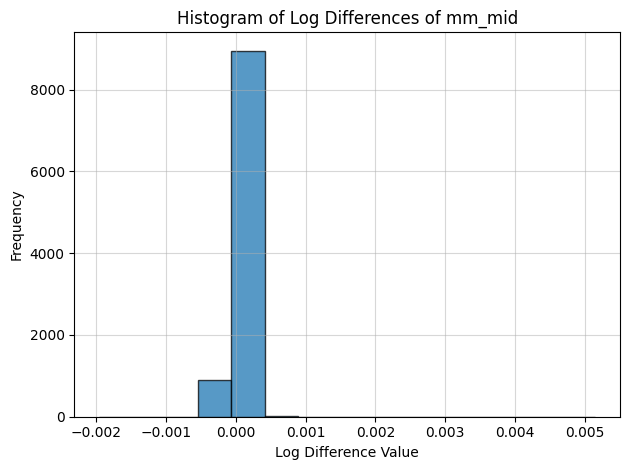

1.2484084052394708e-07 0.0001199636554242691


In [67]:
dfd = np.log(kelp_data['mm_mid']).diff().dropna()
dfd

plt.hist(dfd, bins='auto', alpha=0.75, edgecolor='black')

plt.title(f'Histogram of Log Differences of {dfd.name}')
plt.xlabel('Log Difference Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

mu, std = norm.fit(dfd)
print(mu, std)

In [68]:
# ===========================
# Create the Hypothesized model
# ===========================

df = kelp_data['mm_mid'].dropna()
print(df)
sample = df.values

model = GeometricBM()

# Set bounds for param search, and some psuedo-reasonable initial guess
param_bounds = [(0.0, 0.0), (0.0, 2)]
guess = np.array([0, df.std()])

# ===========================
# Read in the data (interest rate time series)
# ===========================

dt = 100

# ===========================
# Fit maximum Likelihood estimators
# ===========================

# Fit using Kessler MLE
kessler_est = AnalyticalMLE(sample, param_bounds, dt, density=KesslerDensity(model)).estimate_params(guess)

print(f'\nKessler MLE: {kessler_est} \n')

# Fit using Shoji-Ozaki MLE
shojioz_est = AnalyticalMLE(sample, param_bounds, dt, density=ShojiOzakiDensity(model)).estimate_params(guess)

print(f'\nShoji-Ozaki MLE: {shojioz_est}')

/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.



0       2030.0
1       2030.0
2       2030.0
3       2030.5
4       2030.0
         ...  
9995    2033.5
9996    2033.5
9997    2033.5
9998    2033.5
9999    2033.5
Name: mm_mid, Length: 9933, dtype: float64
Initial Params: [0.         2.36525899]
Initial Likelihood: -212819.68319457467
`xtol` termination condition is satisfied.
Number of iterations: 78, function evaluations: 234, CG iterations: 80, optimality: 2.33e+10, constraint violation: 1.68e-14, execution time: 0.14 s.
Final Params: [1.68040537e-14 1.81835372e+00]
Final Likelihood: -180237.71875730404

Kessler MLE: 
params      | [1.68040537e-14 1.81835372e+00] 
sample size | 9932 
likelihood  | -180237.71875730404 
AIC         | 360479.4375146081
BIC         | 360493.84454890137 

Initial Params: [0.         2.36525899]
Initial Likelihood: -116208.9137628362
`xtol` termination condition is satisfied.
Number of iterations: 79, function evaluations: 225, CG iterations: 90, optimality: 9.71e-03, constraint violation: 6.71e-16, exe

Rainforest Resin

In [69]:
resin_data = market_data[market_data['product'] == 'RAINFOREST_RESIN'].reset_index(drop=True)
resin_data['bid_volume_1'].value_counts()

bid_volume_1
1     3148
2     2748
5      268
25     264
24     255
4      250
3      241
27     240
28     232
30     230
26     228
29     223
22     220
23     219
20     217
21     212
6      207
7      164
8      147
9      140
10     124
11      11
12       8
0        2
13       1
15       1
Name: count, dtype: int64

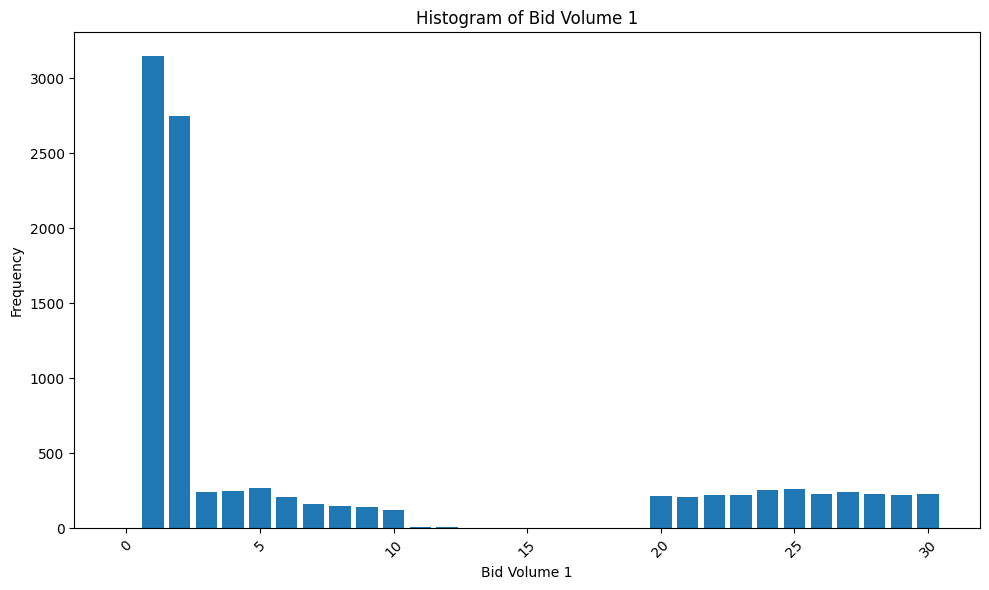

In [70]:
bid_volume_counts = resin_data['bid_volume_1'].value_counts()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(bid_volume_counts.index, bid_volume_counts.values)
plt.xlabel('Bid Volume 1')
plt.ylabel('Frequency')
plt.title('Histogram of Bid Volume 1')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

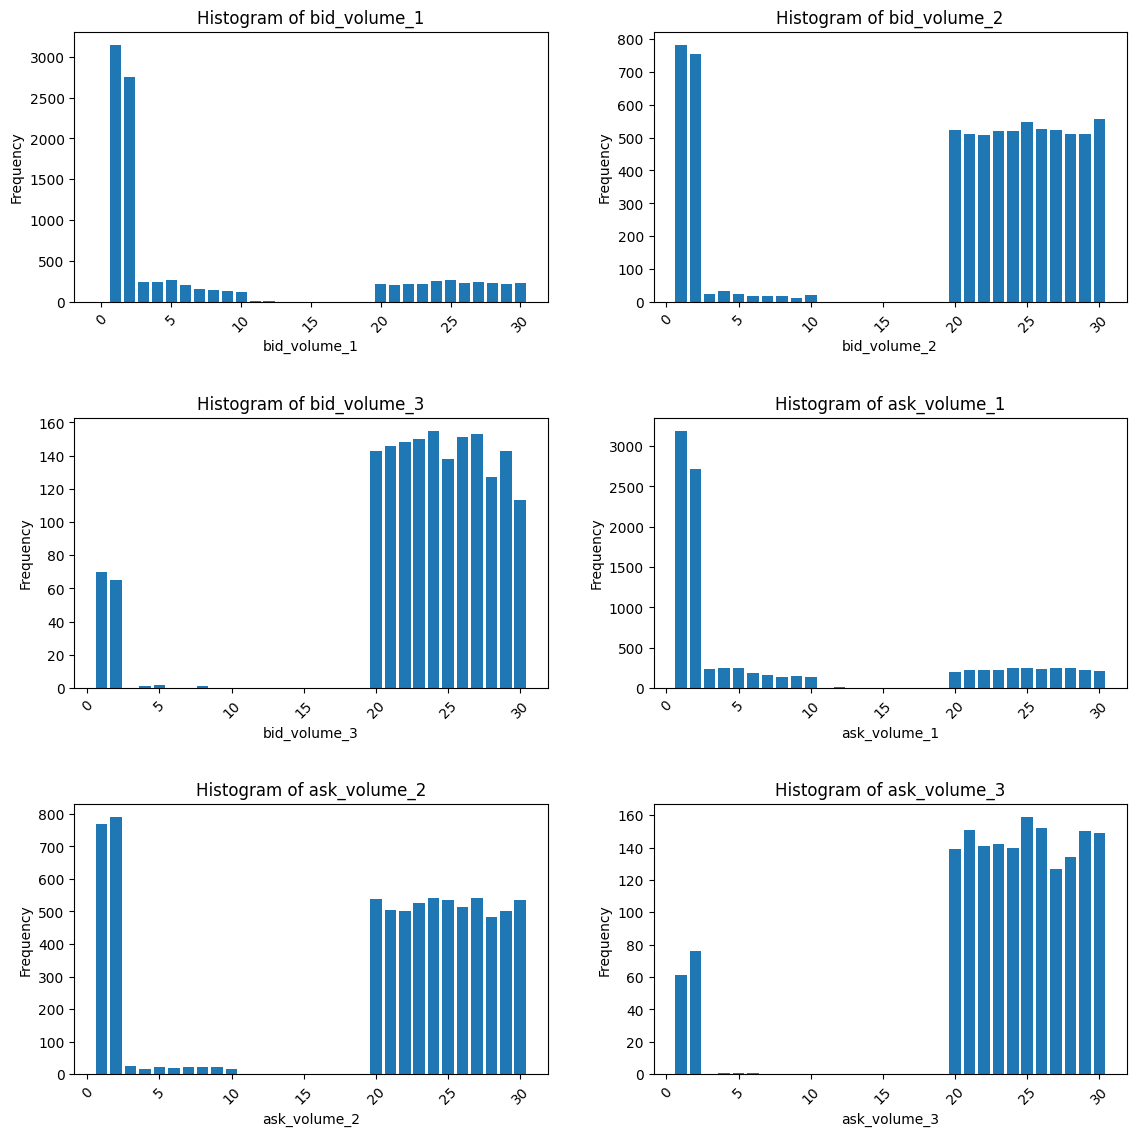

In [71]:
columns_to_plot = ['bid_volume_1', 'bid_volume_2', 'bid_volume_3',
                   'ask_volume_1', 'ask_volume_2', 'ask_volume_3']

num_plots = len(columns_to_plot)
num_rows = (num_plots + 1) // 2
num_cols = 2

plt.figure(figsize=(12, 4 * num_rows))

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(num_rows, num_cols, i)
    
    volume_counts = resin_data[column].value_counts()
    
    plt.bar(volume_counts.index, volume_counts.values)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout(pad=3.0)

plt.show();

In [72]:
def calculate_mm_mid(row):
    # Find the best bid with volume >= 20
    for i in range(1, 4):
        if row[f'bid_volume_{i}'] >= 20:
            best_bid = row[f'bid_price_{i}']
            break
    else:
        best_bid = None

    for i in range(1, 4):
        if row[f'ask_volume_{i}'] >= 20:
            best_ask = row[f'ask_price_{i}']
            break
    else:
        best_ask = None

    # Calculate the mid price if both best bid and ask are found
    if best_bid is not None and best_ask is not None:
        return (best_bid + best_ask) / 2
    else:
        return None

resin_data['mm_mid'] = resin_data.apply(calculate_mm_mid, axis=1)
resin_data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,mm_mid
0,0,0,RAINFOREST_RESIN,9998,1,9995.0,30.0,NaN,NaN,10005,30,NaN,NaN,NaN,NaN,10001.5,0.0,10000.0
1,0,100,RAINFOREST_RESIN,9996,1,9995.0,30.0,NaN,NaN,10002,6,10004.0,1.0,10005.0,30.0,9999.0,0.0,10000.0
2,0,200,RAINFOREST_RESIN,9996,1,9995.0,21.0,NaN,NaN,10004,1,10005.0,21.0,NaN,NaN,10000.0,0.0,10000.0
3,0,300,RAINFOREST_RESIN,9996,2,9995.0,23.0,NaN,NaN,9998,3,10004.0,2.0,10005.0,23.0,9997.0,0.0,10000.0
4,0,400,RAINFOREST_RESIN,9998,5,9996.0,2.0,9995.0,23.0,10004,2,10005.0,23.0,NaN,NaN,10001.0,0.0,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,999500,RAINFOREST_RESIN,9995,28,NaN,NaN,NaN,NaN,10002,6,10005.0,28.0,NaN,NaN,9998.5,0.0,10000.0
9996,0,999600,RAINFOREST_RESIN,9996,2,9995.0,27.0,NaN,NaN,10002,3,10004.0,2.0,10005.0,27.0,9999.0,0.0,10000.0
9997,0,999700,RAINFOREST_RESIN,9996,2,9995.0,24.0,NaN,NaN,10004,2,10005.0,24.0,NaN,NaN,10000.0,0.0,10000.0
9998,0,999800,RAINFOREST_RESIN,9995,27,NaN,NaN,NaN,NaN,10005,27,NaN,NaN,NaN,NaN,10000.0,0.0,10000.0


In [73]:
# Create the plot using Plotly Express
fig = px.line(resin_data, x='timestamp', y='mm_mid', title='MM Mid Price Over Time')

# Customize the layout
fig.update_layout(
    xaxis_title='Timestamp',
    yaxis_title='MM Mid Price',
)

# Display the plot
fig.show()


In [74]:
resin_fair_prices = resin_data[['timestamp', 'mm_mid']]
resin_fair_prices

,timestamp,mm_mid
0,0,10000.0
1,100,10000.0
2,200,10000.0
3,300,10000.0
4,400,10000.0
...,...,...
9995,999500,10000.0
9996,999600,10000.0
9997,999700,10000.0
9998,999800,10000.0


In [75]:
# ===========================
# Create the Hypothesized model
# ===========================

df = resin_data['mm_mid'].dropna()
print(df)
sample = df.values

model = OrnsteinUhlenbeck()

# Set bounds for param search, and some psuedo-reasonable initial guess
param_bounds = [(0.0, 10000), (0.0, 10000), (0.0, 10000)]
guess = np.array([df.mean(), 0.1, 0.1])

# ===========================
# Read in the data (interest rate time series)
# ===========================

dt = 100
# ===========================
# Fit maximum Likelihood estimators
# ===========================

# Fit using Kessler MLE
kessler_est = AnalyticalMLE(sample, param_bounds, dt, density=KesslerDensity(model)).estimate_params(guess)

print(f'\nKessler MLE: {kessler_est} \n')

# Fit using Shoji-Ozaki MLE
shojioz_est = AnalyticalMLE(sample, param_bounds, dt, density=ShojiOzakiDensity(model)).estimate_params(guess)

print(f'\nShoji-Ozaki MLE: {shojioz_est}')

0       10000.0
1       10000.0
2       10000.0
3       10000.0
4       10000.0
         ...   
9995    10000.0
9996    10000.0
9997    10000.0
9998    10000.0
9999    10000.0
Name: mm_mid, Length: 9721, dtype: float64
Initial Params: [1.e+04 1.e-01 1.e-01]
Initial Likelihood: -365152.608390277
`xtol` termination condition is satisfied.
Number of iterations: 55, function evaluations: 224, CG iterations: 95, optimality: 9.24e+02, constraint violation: 0.00e+00, execution time: 0.084 s.
Final Params: [9.99677493e+03 5.25339772e+01 1.08093975e+00]
Final Likelihood: -365095.2371292262

Kessler MLE: 
params      | [9.99677493e+03 5.25339772e+01 1.08093975e+00] 
sample size | 9720 
likelihood  | -365095.2371292262 
AIC         | 730196.4742584524
BIC         | 730218.0200811448 

Initial Params: [1.e+04 1.e-01 1.e-01]
Initial Likelihood: -671433.8131170634
`gtol` termination condition is satisfied.
Number of iterations: 10, function evaluations: 12, CG iterations: 2, optimality: 4.23e-07, co

/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.



Squid Ink

In [76]:
squink_data = market_data[market_data['product'] == 'SQUID_INK'].reset_index(drop=True)
squink_data['bid_volume_1'].value_counts()

bid_volume_1
1     933
27    717
28    699
24    699
30    697
26    694
25    690
29    668
22    658
23    617
31    478
21    450
2     345
32    275
20    234
3     171
4     164
5     163
6     111
7      79
8      76
33     68
34     56
35     43
36     34
9      34
37     27
19     23
38     21
39     14
10     13
18     12
17     11
15      7
16      6
12      3
14      3
11      3
13      3
40      1
Name: count, dtype: int64

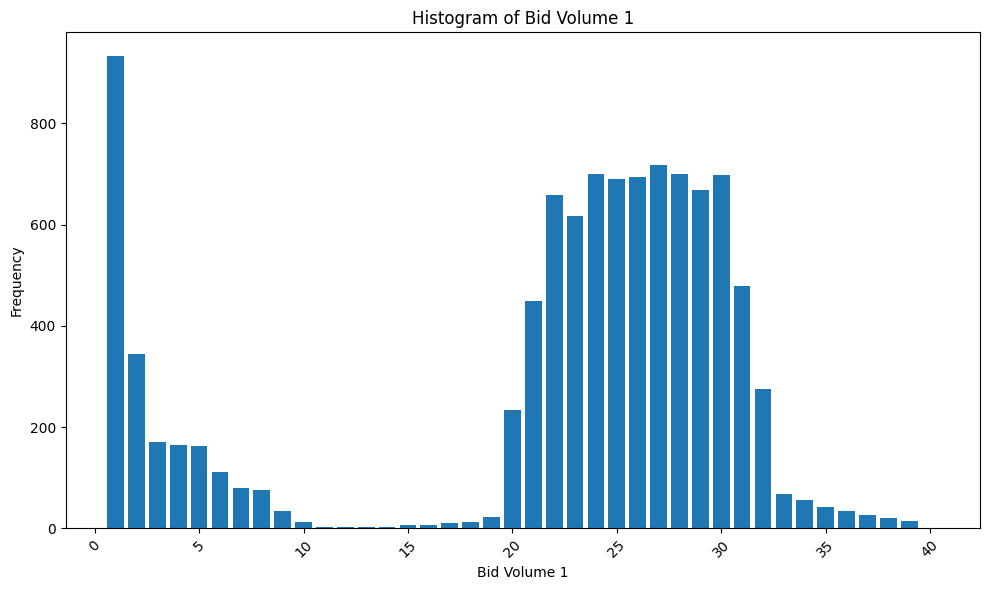

In [77]:
bid_volume_counts = squink_data['bid_volume_1'].value_counts()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(bid_volume_counts.index, bid_volume_counts.values)
plt.xlabel('Bid Volume 1')
plt.ylabel('Frequency')
plt.title('Histogram of Bid Volume 1')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

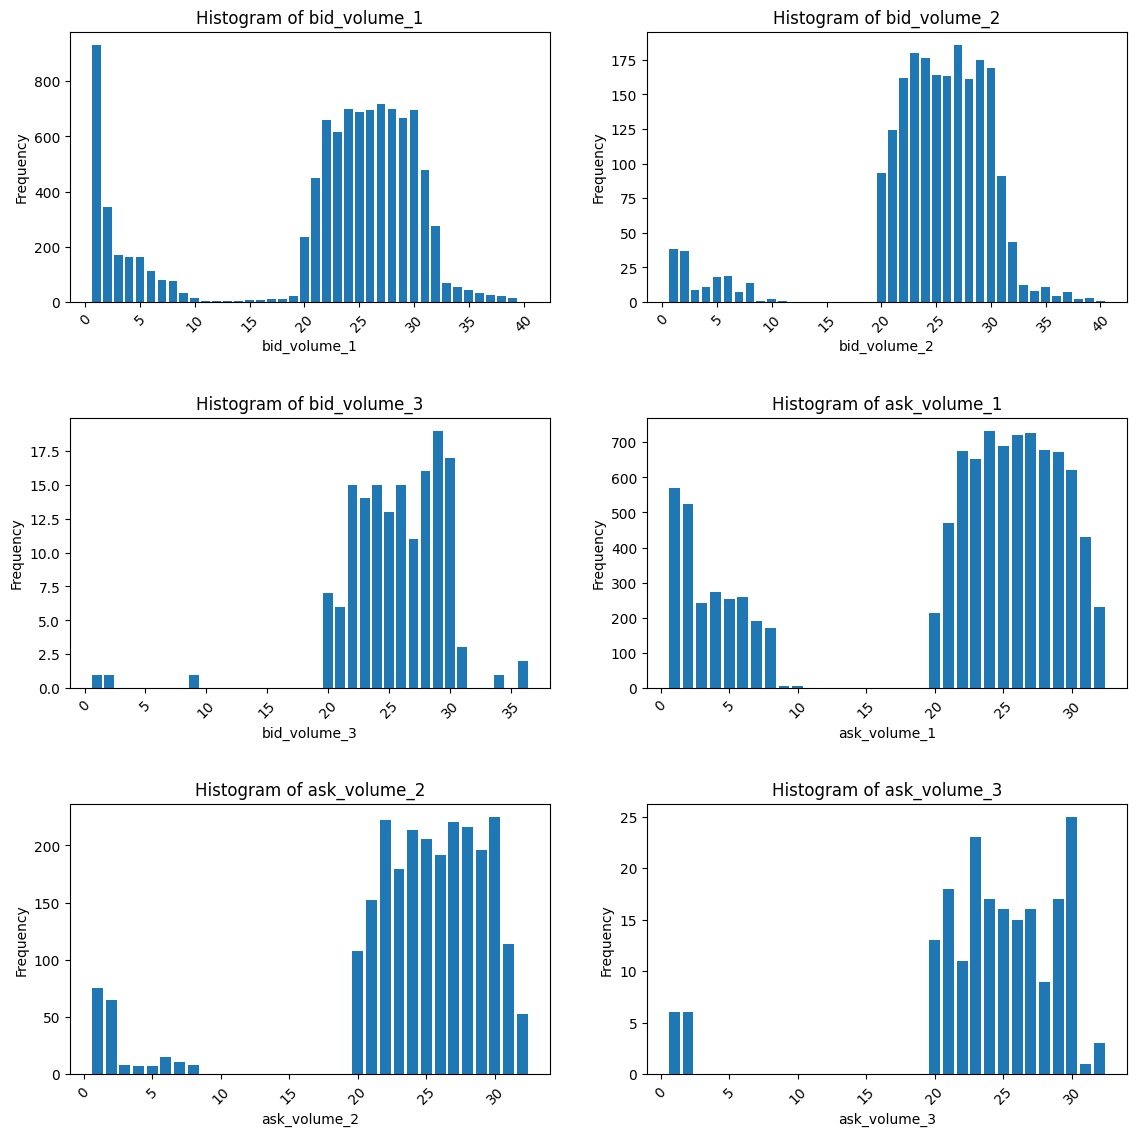

In [78]:
columns_to_plot = ['bid_volume_1', 'bid_volume_2', 'bid_volume_3',
                   'ask_volume_1', 'ask_volume_2', 'ask_volume_3']

num_plots = len(columns_to_plot)
num_rows = (num_plots + 1) // 2
num_cols = 2

plt.figure(figsize=(12, 4 * num_rows))

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(num_rows, num_cols, i)
    
    volume_counts = squink_data[column].value_counts()
    
    plt.bar(volume_counts.index, volume_counts.values)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout(pad=3.0)

plt.show();

In [79]:
def calculate_mm_mid(row):
    for i in range(1, 4):
        if row[f'bid_volume_{i}'] >= 20:
            best_bid = row[f'bid_price_{i}']
            break
    else:
        best_bid = None

    for i in range(1, 4):
        if row[f'ask_volume_{i}'] >= 20:
            best_ask = row[f'ask_price_{i}']
            break
    else:
        best_ask = None

    # Calculate the mid price if both best bid and ask are found
    if best_bid is not None and best_ask is not None:
        return (best_bid + best_ask) / 2
    else:
        return None

squink_data['mm_mid'] = squink_data.apply(calculate_mm_mid, axis=1)
squink_data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,mm_mid
0,0,0,SQUID_INK,1968,30,NaN,NaN,NaN,NaN,1971,30,NaN,NaN,NaN,NaN,1969.5,0.0,1969.5
1,0,100,SQUID_INK,1969,4,1967.0,31.0,NaN,NaN,1971,31,NaN,NaN,NaN,NaN,1970.0,0.0,1969.0
2,0,200,SQUID_INK,1966,1,1965.0,21.0,NaN,NaN,1969,22,NaN,NaN,NaN,NaN,1967.5,0.0,1967.0
3,0,300,SQUID_INK,1965,25,NaN,NaN,NaN,NaN,1968,25,NaN,NaN,NaN,NaN,1966.5,0.0,1966.5
4,0,400,SQUID_INK,1966,25,NaN,NaN,NaN,NaN,1968,6,1969.0,25.0,NaN,NaN,1967.0,0.0,1967.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,999500,SQUID_INK,1830,28,NaN,NaN,NaN,NaN,1833,28,NaN,NaN,NaN,NaN,1831.5,0.0,1831.5
9996,0,999600,SQUID_INK,1832,7,1831.0,29.0,NaN,NaN,1834,2,1835.0,27.0,NaN,NaN,1833.0,0.0,1833.0
9997,0,999700,SQUID_INK,1834,1,1832.0,26.0,NaN,NaN,1835,26,NaN,NaN,NaN,NaN,1834.5,0.0,1833.5
9998,0,999800,SQUID_INK,1837,27,NaN,NaN,NaN,NaN,1839,1,1840.0,27.0,NaN,NaN,1838.0,0.0,1838.5


In [80]:
# Create the plot using Plotly Express
fig = px.line(squink_data, x='timestamp', y='mm_mid', title='MM Mid Price Over Time')

# Customize the layout
fig.update_layout(
    xaxis_title='Timestamp',
    yaxis_title='MM Mid Price',
)

# Display the plot
fig.show()

In [81]:
squink_fair_prices = squink_data[['timestamp', 'mm_mid']]

In [82]:
squink_fair_prices = squink_fair_prices.rename(columns={'mm_mid': 'fair'})
squink_fair_prices

,timestamp,fair
0,0,1969.5
1,100,1969.0
2,200,1967.0
3,300,1966.5
4,400,1967.5
...,...,...
9995,999500,1831.5
9996,999600,1833.0
9997,999700,1833.5
9998,999800,1838.5


In [83]:
iteration_counts = [1,2,5,10,50, 100, 500,]

In [84]:
for iterations in iteration_counts:
    squink_fair_prices[f"fair_in_{iterations}_its"] = squink_fair_prices['fair'].shift(-iterations)
    squink_fair_prices[f"fair_{iterations}_its_ago"] = squink_fair_prices['fair'].shift(iterations)
squink_fair_prices

,timestamp,fair,fair_in_1_its,fair_1_its_ago,fair_in_2_its,fair_2_its_ago,fair_in_5_its,fair_5_its_ago,fair_in_10_its,fair_10_its_ago,fair_in_50_its,fair_50_its_ago,fair_in_100_its,fair_100_its_ago,fair_in_500_its,fair_500_its_ago
0,0,1969.5,1969.0,NaN,1967.0,NaN,1968.0,NaN,1968.5,NaN,1973.0,NaN,1983.0,NaN,1956.0,NaN
1,100,1969.0,1967.0,1969.5,1966.5,NaN,1966.5,NaN,1969.5,NaN,1972.5,NaN,1984.0,NaN,1954.5,NaN
2,200,1967.0,1966.5,1969.0,1967.5,1969.5,1968.5,NaN,1969.5,NaN,1973.0,NaN,1982.5,NaN,1955.0,NaN
3,300,1966.5,1967.5,1967.0,1968.0,1969.0,1968.5,NaN,1969.5,NaN,1972.5,NaN,1983.0,NaN,1954.0,NaN
4,400,1967.5,1968.0,1966.5,1966.5,1967.0,1968.0,NaN,1970.0,NaN,1973.5,NaN,1984.0,NaN,1955.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,999500,1831.5,1833.0,1830.5,1833.5,1832.5,NaN,1832.5,NaN,1841.5,NaN,1851.0,NaN,1862.5,NaN,1860.5
9996,999600,1833.0,1833.5,1831.5,1838.5,1830.5,NaN,1831.5,NaN,1841.0,NaN,1849.5,NaN,1861.5,NaN,1861.5
9997,999700,1833.5,1838.5,1833.0,1839.5,1831.5,NaN,1832.5,NaN,1839.5,NaN,NaN,NaN,1862.5,NaN,1860.5
9998,999800,1838.5,1839.5,1833.5,NaN,1833.0,NaN,1832.5,NaN,1833.0,NaN,1846.5,NaN,1862.5,NaN,1858.5


In [85]:
for iterations in iteration_counts:
    squink_fair_prices[f'returns_in_{iterations}_its'] = (squink_fair_prices[f'fair_in_{iterations}_its'] - squink_fair_prices['fair'])/squink_fair_prices['fair']
    squink_fair_prices[f'returns_from_{iterations}_its_ago'] = (squink_fair_prices['fair'] - squink_fair_prices[f'fair_{iterations}_its_ago'])/squink_fair_prices[f'fair_{iterations}_its_ago']
squink_fair_prices.columns

Index(['timestamp', 'fair', 'fair_in_1_its', 'fair_1_its_ago', 'fair_in_2_its',
       'fair_2_its_ago', 'fair_in_5_its', 'fair_5_its_ago', 'fair_in_10_its',
       'fair_10_its_ago', 'fair_in_50_its', 'fair_50_its_ago',
       'fair_in_100_its', 'fair_100_its_ago', 'fair_in_500_its',
       'fair_500_its_ago', 'returns_in_1_its', 'returns_from_1_its_ago',
       'returns_in_2_its', 'returns_from_2_its_ago', 'returns_in_5_its',
       'returns_from_5_its_ago', 'returns_in_10_its',
       'returns_from_10_its_ago', 'returns_in_50_its',
       'returns_from_50_its_ago', 'returns_in_100_its',
       'returns_from_100_its_ago', 'returns_in_500_its',
       'returns_from_500_its_ago'],
      dtype='object')

In [86]:
squink_returns = squink_fair_prices[['timestamp','fair','returns_in_1_its', 'returns_from_1_its_ago',
       'returns_in_2_its', 'returns_from_2_its_ago', 'returns_in_5_its',
       'returns_from_5_its_ago', 'returns_in_10_its',
       'returns_from_10_its_ago', 'returns_in_50_its',
       'returns_from_50_its_ago', 'returns_in_100_its',
       'returns_from_100_its_ago', 'returns_in_500_its',
       'returns_from_500_its_ago']]

In [87]:
squink_returns= squink_returns.dropna()
squink_returns

,timestamp,fair,returns_in_1_its,returns_from_1_its_ago,returns_in_2_its,returns_from_2_its_ago,returns_in_5_its,returns_from_5_its_ago,returns_in_10_its,returns_from_10_its_ago,returns_in_50_its,returns_from_50_its_ago,returns_in_100_its,returns_from_100_its_ago,returns_in_500_its,returns_from_500_its_ago
500,50000,1956.0,-0.000767,0.000000,-0.000511,0.001280,-0.000767,0.001793,-0.002301,0.001793,-0.003067,0.003334,-0.003834,-0.000766,0.006646,-0.006855
501,50100,1954.5,0.000256,-0.000767,-0.000256,-0.000767,-0.000512,0.001024,-0.001535,0.000768,-0.001535,0.003079,-0.004093,-0.000511,0.006907,-0.007364
502,50200,1955.0,-0.000512,0.000256,0.000256,-0.000511,-0.001279,0.001024,-0.001790,0.000768,-0.002302,0.003336,-0.005115,0.000256,0.006905,-0.006101
503,50300,1954.0,0.000768,-0.000512,0.000256,-0.000256,-0.000768,0.000256,-0.002303,0.000512,-0.002047,0.002823,-0.003327,-0.000512,0.006909,-0.006356
504,50400,1955.5,-0.000511,0.000768,-0.001023,0.000256,-0.001534,-0.000256,-0.002557,0.001280,-0.002557,0.003593,-0.004602,0.001793,0.006904,-0.006099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9494,949400,1860.5,0.000000,0.000000,0.000537,0.000269,-0.002150,0.000538,-0.003762,-0.000537,-0.006450,-0.003215,0.004837,-0.003215,-0.016125,0.005676
9496,949600,1861.5,-0.000537,0.000537,-0.001612,0.000537,-0.004029,0.000537,-0.005909,0.000537,-0.005909,-0.002144,0.004298,-0.002144,-0.015310,0.006488
9497,949700,1860.5,-0.001075,-0.000537,-0.002150,0.000000,-0.003225,0.000269,-0.005106,0.000538,-0.004837,-0.003215,0.004837,-0.002145,-0.014512,0.005404
9498,949800,1858.5,-0.001076,-0.001075,-0.001345,-0.001612,-0.003228,-0.001075,-0.004305,-0.000538,-0.004305,-0.003752,0.006188,-0.002683,-0.010761,0.004323


In [88]:
# Perform train-test split
train_data, test_data = train_test_split(squink_returns, test_size=0.2, random_state=42)

# Iterate over each iteration count
for iterations in tqdm(iteration_counts):
    # Prepare the feature and target columns
    X_train = train_data[f'returns_from_{iterations}_its_ago'].values.reshape(-1, 1)
    y_train = train_data[f'returns_in_{iterations}_its']
    X_test = test_data[f'returns_from_{iterations}_its_ago'].values.reshape(-1, 1)
    y_test = test_data[f'returns_in_{iterations}_its']

    # Create and train the linear regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)

    # Make predictions on train and test data
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Calculate R-squared and MSE for train and test data
    train_r2 = r2_score(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    # Print the results
    print(f"Iteration Count: {iterations}")
    print(f"Learned Equation: returns_in_{iterations}_its = {model.coef_[0]:.4f} * returns_from_{iterations}_its_ago")
    print(f"Train R-squared: {train_r2:.4f}")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test R-squared: {test_r2:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print()

100%|██████████| 7/7 [00:00<00:00, 887.98it/s]

Iteration Count: 1
Learned Equation: returns_in_1_its = -0.0975 * returns_from_1_its_ago
Train R-squared: 0.0094
Train MSE: 0.0000
Test R-squared: 0.0068
Test MSE: 0.0000

Iteration Count: 2
Learned Equation: returns_in_2_its = -0.0330 * returns_from_2_its_ago
Train R-squared: 0.0010
Train MSE: 0.0000
Test R-squared: 0.0012
Test MSE: 0.0000

Iteration Count: 5
Learned Equation: returns_in_5_its = 0.0614 * returns_from_5_its_ago
Train R-squared: 0.0036
Train MSE: 0.0000
Test R-squared: 0.0051
Test MSE: 0.0000

Iteration Count: 10
Learned Equation: returns_in_10_its = 0.0968 * returns_from_10_its_ago
Train R-squared: 0.0090
Train MSE: 0.0000
Test R-squared: 0.0094
Test MSE: 0.0000

Iteration Count: 50
Learned Equation: returns_in_50_its = -0.0466 * returns_from_50_its_ago
Train R-squared: -0.0014
Train MSE: 0.0000
Test R-squared: 0.0026
Test MSE: 0.0000

Iteration Count: 100
Learned Equation: returns_in_100_its = -0.1867 * returns_from_100_its_ago
Train R-squared: 0.0288
Train MSE: 0.000

In [89]:
# ===========================
# Create the Hypothesized model
# ===========================

df = squink_data['mm_mid'].dropna()
print(df)
sample = df.values

model = GeometricBM()

# Set bounds for param search, and some psuedo-reasonable initial guess
param_bounds = [(0.0, 10000), (0.0, 10000)]
guess = np.array([df.mean(), df.std()])

# ===========================
# Read in the data (interest rate time series)
# ===========================

dt = 100

# ===========================
# Fit maximum Likelihood estimators
# ===========================

# Fit using Kessler MLE
kessler_est = AnalyticalMLE(sample, param_bounds, dt, density=KesslerDensity(model)).estimate_params(guess)

print(f'\nKessler MLE: {kessler_est} \n')

# Fit using Shoji-Ozaki MLE
shojioz_est = AnalyticalMLE(sample, param_bounds, dt, density=ShojiOzakiDensity(model)).estimate_params(guess)

print(f'\nShoji-Ozaki MLE: {shojioz_est}')

0       1969.5
1       1969.0
2       1967.0
3       1966.5
4       1967.5
         ...  
9995    1831.5
9996    1833.0
9997    1833.5
9998    1838.5
9999    1839.5
Name: mm_mid, Length: 9917, dtype: float64
Initial Params: [1907.94761521   42.67172675]
Initial Likelihood: -323200.17852674576
`xtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 75, CG iterations: 31, optimality: 6.98e+07, constraint violation: 0.00e+00, execution time: 0.032 s.
Final Params: [1907.94760662   42.6901689 ]
Final Likelihood: -323190.9601681612

Kessler MLE: 
params      | [1907.94760662   42.6901689 ] 
sample size | 9916 
likelihood  | -323190.9601681612 
AIC         | 646385.9203363224
BIC         | 646400.3241461087 

Initial Params: [1907.94761521   42.67172675]
Initial Likelihood: nan
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execu

/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/pymle/core/TransitionDensity.py:163: RuntimeWarning:

overflow encountered in exp

/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/pymle/core/TransitionDensity.py:165: RuntimeWarning:

overflow encountered in exp

/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/pymle/core/TransitionDensity.py:166: RuntimeWarning:

invalid value encountered in multiply

/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/pymle/core/TransitionDensity.py:166: RuntimeWarning:

invalid value encountered in add

/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/pymle/core/TransitionDensity.py:168: RuntimeWarning:

invalid value encountered in divide



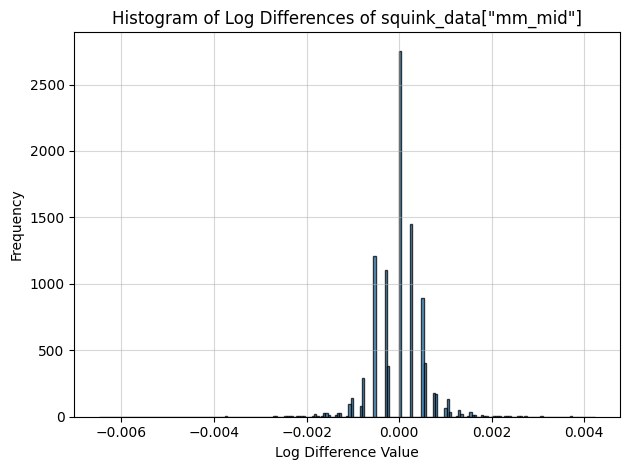

-6.424652273823348e-06 0.0005829689227674438


In [90]:
dfd = np.log(squink_data['mm_mid']).diff().dropna()
dfd

plt.hist(dfd, bins='auto', alpha=0.75, edgecolor='black')

plt.title('Histogram of Log Differences of squink_data["mm_mid"]')
plt.xlabel('Log Difference Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

mu, std = norm.fit(dfd)
print(mu, std)

In [91]:
# Assumes kelp_data, resin_data, squink_data DataFrames exist and are aligned
combined_df = pd.DataFrame({
    'kelp_mm_mid': kelp_data['mm_mid'],
    'resin_mm_mid': resin_data['mm_mid'],
    'squink_mm_mid': squink_data['mm_mid']
})

combined_df['kelp_next_mm_mid'] = combined_df['kelp_mm_mid'].shift(-1)
regression_data = combined_df.dropna()

X = regression_data[['resin_mm_mid', 'squink_mm_mid']]
y = regression_data['kelp_next_mm_mid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

test_predictions = model.predict(X_test)
test_r2 = r2_score(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print(f"Intercept: {model.intercept_:.4f}")
print(f"Coefficients (Resin, Squink): {model.coef_[0]:.4f}, {model.coef_[1]:.4f}")
print(f"Test R-squared: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

Intercept: 2067.8447
Coefficients (Resin, Squink): -0.0000, -0.0174
Test R-squared: 0.0936
Test MSE: 5.2577


In [ ]:
pd.options.display.max_rows = 500
market_data = pd.read_csv(f'Prosperity25/data/round1/combined_prices_round_1.csv', sep=',', header=0)
market_data

In [ ]:
combined_df = pd.DataFrame({
    'kelp_mm_mid': kelp_data['mm_mid'],
    'resin_mm_mid': resin_data['mm_mid'],
    'squink_mm_mid': squink_data['mm_mid']
})
combined_df['kelp_next_mm_mid'] = combined_df['kelp_mm_mid'].shift(-1)
combined_df['squink_next_mm_mid'] = combined_df['squink_mm_mid'].shift(-1)

regression_data = combined_df.dropna()


X_kelp = regression_data[['kelp_mm_mid']]
y_kelp = regression_data['kelp_next_mm_mid']

X_kelp_train, X_kelp_test, y_kelp_train, y_kelp_test = train_test_split(
    X_kelp, y_kelp, test_size=0.2, random_state=42
)

kelp_pipe_quad_self = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear', LinearRegression(fit_intercept=True))
])

kelp_pipe_quad_self.fit(X_kelp_train, y_kelp_train)

kelp_test_pred_quad = kelp_pipe_quad_self.predict(X_kelp_test)
kelp_test_r2_quad = r2_score(y_kelp_test, kelp_test_pred_quad)
kelp_test_mse_quad = mean_squared_error(y_kelp_test, kelp_test_pred_quad)

poly_features_kelp_quad = kelp_pipe_quad_self.named_steps['poly'].get_feature_names_out(X_kelp.columns)
coeffs_kelp_array = kelp_pipe_quad_self.named_steps['linear'].coef_
intercept_kelp_quad = kelp_pipe_quad_self.named_steps['linear'].intercept_

coeff_kelp = [intercept_kelp_quad] + coeffs_kelp_array.tolist()
coeff_kelp_names = ['intercept'] + poly_features_kelp_quad.tolist()
print(coeff_kelp)

print("\n--- Fitting Quadratic (Kelp only) Model for KELP Next Price ---")
print("Predicting KELP ~ intercept + c1*Kelp + c2*Kelp^2")
print("Coefficients:")
for name, coef in zip(coeff_kelp_names, coeff_kelp): print(f"  {name}: {coef:.6f}")
print(f"Test R-squared: {kelp_test_r2_quad:.4f}")
print(f"Test MSE: {kelp_test_mse_quad:.4f}")
print("-" * 40)


X_squink = regression_data[['squink_mm_mid']]
y_squink = regression_data['squink_next_mm_mid']

X_squink_train, X_squink_test, y_squink_train, y_squink_test = train_test_split(
    X_squink, y_squink, test_size=0.2, random_state=42
)

squink_pipe_quad_self = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear', LinearRegression(fit_intercept=True))
])

squink_pipe_quad_self.fit(X_squink_train, y_squink_train)

squink_test_pred_quad = squink_pipe_quad_self.predict(X_squink_test)
squink_test_r2_quad = r2_score(y_squink_test, squink_test_pred_quad)
squink_test_mse_quad = mean_squared_error(y_squink_test, squink_test_pred_quad)

poly_features_squink_quad = squink_pipe_quad_self.named_steps['poly'].get_feature_names_out(X_squink.columns)
coeffs_squink_array = squink_pipe_quad_self.named_steps['linear'].coef_
intercept_squink_quad = squink_pipe_quad_self.named_steps['linear'].intercept_

coeff_squink = [intercept_squink_quad] + coeffs_squink_array.tolist()
coeff_squink_names = ['intercept'] + poly_features_squink_quad.tolist()
print(coeff_squink)

print("\n--- Fitting Quadratic (Squink only) Model for SQUID INK Next Price ---")
print("Predicting SQUID_INK ~ intercept + c1*Squink + c2*Squink^2")
print("Coefficients:")
for name, coef in zip(coeff_squink_names, coeff_squink): print(f"  {name}: {coef:.6f}")
print(f"Test R-squared: {squink_test_r2_quad:.4f}")
print(f"Test MSE: {squink_test_mse_quad:.4f}")
print("-" * 40)

[-7514.287362514866, 8.396289600490656, -0.0018200302192571034]

--- Fitting Quadratic (Kelp only) Model for KELP Next Price ---
Predicting KELP ~ intercept + c1*Kelp + c2*Kelp^2
Coefficients:
  intercept: -7514.287363
  kelp_mm_mid: 8.396290
  kelp_mm_mid^2: -0.001820
Test R-squared: 0.9915
Test MSE: 0.0490
----------------------------------------
[-3.57941403304676, 1.0039476694835787, -1.0891353395876743e-06]

--- Fitting Quadratic (Squink only) Model for SQUID INK Next Price ---
Predicting SQUID_INK ~ intercept + c1*Squink + c2*Squink^2
Coefficients:
  intercept: -3.579414
  squink_mm_mid: 1.003948
  squink_mm_mid^2: -0.000001
Test R-squared: 0.9993
Test MSE: 1.2591
----------------------------------------


      mm_mid  mm_mid
0     1969.5  2030.0
1     1969.0  2030.0
2     1967.0  2030.0
3     1966.5  2030.5
4     1967.5  2030.0
...      ...     ...
9995  1831.5  2033.5
9996  1833.0  2033.5
9997  1833.5  2033.5
9998  1838.5  2033.5
9999  1839.5  2033.5

[9892 rows x 2 columns]
[19.22487874  1.4398849 ]
[17.78499384  1.4398849 ]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[0.00179666 0.00014558]
[0.00538376 0.44370232]


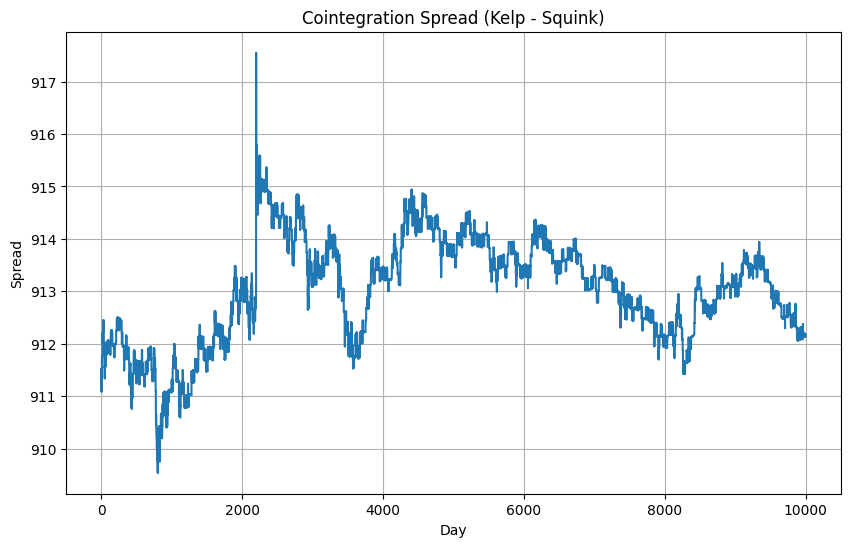

In [93]:
squink_data['spread'] = squink_data['mm_mid'].values - kelp_data['mm_mid'].values

# Create the plot using Plotly Express
fig = px.line(squink_data, x='timestamp', y='spread', title='Spread Over Time')

# Customize the layout
fig.update_layout(
    xaxis_title='Timestamp',
    yaxis_title='Spread Price',
)

# Display the plot
fig.show()

spread_data=pd.concat([squink_data['mm_mid'], kelp_data['mm_mid']], axis=1).dropna()
print(spread_data)
result = coint_johansen(spread_data, det_order=0, k_ar_diff=1)

print(result.lr1)
print(result.lr2)
print(result.cvm)
print(result.cvt)
print(result.eig)

coint_vector = result.evec[:, 0]
print(coint_vector)
spread = np.dot(spread_data, coint_vector)
spread.mean()

plt.figure(figsize=(10, 6))
plt.plot(spread_data.index, spread,label = 'Cointegration Spread') 
plt.title('Cointegration Spread (Kelp - Squink)')
plt.xlabel('Day')
plt.ylabel('Spread')
plt.grid(True)